In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
import plotly.graph_objects as go


### Correlation Matrix

In [2]:

df = pd.read_csv(r"C:\Users\MadiL\Thesis CodeBase\Cross-Sectional\lsas_together.csv")

lsas_columns = [col for col in df.columns if "LSAS" in col]
cfs_columns = [col for col in df.columns if "CFS" in col]
bdi_columns = [col for col in df.columns if "BDI" in col]


# Subset the dataframe
### If we want to use demographics, don't subset
df_subset = df[lsas_columns + cfs_columns + bdi_columns].copy()

#df_subset[cfs_columns] = abs(df_subset[cfs_columns])

# Reverse score CFS questions 2, 3, 5, 10 in place
reverse_columns = ['CFS_2', 'CFS_3', 'CFS_5', 'CFS_10']

# Apply the reverse scoring transformation in place
df_subset[reverse_columns] = 7 - df_subset[reverse_columns]

# Reverse the direction of all CFS columns by multiplying by -1
df_subset[cfs_columns] = df_subset[cfs_columns] * -1


# Define a function to standardize values
# Ensures all columns have a mean of 0 and a standard deviation of 1
def standardize(df_column):
    return (df_column - df_column.mean()) / df_column.std()

# Standardize LSAS columns
df_subset[lsas_columns] = df_subset[lsas_columns].apply(standardize)

# Standardize CFS columns
df_subset[cfs_columns] = df_subset[cfs_columns].apply(standardize)

# Standardize BDI columns
df_subset[bdi_columns] = df_subset[bdi_columns].apply(standardize)

# Create a new DataFrame containing all the standardized individual items
df_standardized = df_subset[lsas_columns + cfs_columns + bdi_columns]

# Display the first few rows of the standardized data for inspection
print("Standardized Data Sample:")
print(df_standardized.head())

# Compute the correlation matrix for the standardized data
standardized_correlation_matrix = df_standardized.corr()

# Display the correlation matrix for review
print("Correlation Matrix:")
print(standardized_correlation_matrix)



Standardized Data Sample:
     LSAS_1    LSAS_2    LSAS_3    LSAS_4    LSAS_5    LSAS_6    LSAS_7  \
0 -0.335228 -0.502132 -0.024781 -0.068952 -0.723623 -1.158135 -0.624364   
1 -0.930409 -1.088625 -0.688218 -0.678930 -1.335395 -1.641470 -1.153245   
2 -0.930409 -1.088625 -0.688218 -0.678930 -1.335395 -0.674800 -1.153245   
3  1.450315  0.084361  1.965531  1.760982 -0.111851  0.291870  1.491160   
4  0.259953  1.257347 -0.688218 -0.678930  1.111693  1.258540 -0.095483   

     LSAS_8    LSAS_9   LSAS_10  ...  BDI_Loss_Of_Interest  \
0 -1.372456 -1.102744 -1.410507  ...              0.465975   
1 -1.372456 -1.102744 -1.410507  ...             -0.758966   
2 -0.241588  0.017248 -0.285051  ...              1.690916   
3  1.454715  0.577243  1.965859  ...             -0.758966   
4  0.889280  0.017248  0.277676  ...             -0.758966   

   BDI_Indecisiveness  BDI_Worthlessness  BDI_Loss_Of_Energy  \
0            2.115305          -0.609045           -0.876312   
1           -0.564052 

### Building a Network

In [3]:
correlation_matrix = standardized_correlation_matrix
# Set a correlation threshold to define a "strong" connection
threshold = 0.4

# Initialize an empty graph
G = nx.Graph()

# Add edges for pairs of questions that have a correlation above the threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if np.abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j],
                       weight=correlation_matrix.iloc[i, j])
            

# Number of nodes in the graph
print(f"Number of nodes: {G.number_of_nodes()}")

# Number of edges in the graph
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 56
Number of edges: 444


This loop goes through every pair of questions in your dataset:

i and j represent the indices of two different questions (columns) in the correlation matrix.
The if statement checks whether the absolute value of the correlation between these two questions is greater than the threshold you set (0.3).

If the correlation is strong enough, an edge is added to the graph, connecting the two questions.
Why It’s Important: This step is how you build your network. Each edge in the network represents a significant relationship between two symptoms. The weight of the edge is the correlation value, which can be useful if you want to consider the strength of the connections in later analysis. 

### Analyze the Network

Identify Central Symptoms: Find out which questions (symptoms) are most central or influential in the network using measures like degree centrality.

Detect Clusters: Look for clusters or communities of symptoms that are closely connected, which might indicate groups of symptoms that co-occur or influence each other.


In [4]:
# Centrality analysis
centrality = nx.degree_centrality(G)
print("Most central symptoms:", sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10])

# Community detection
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
print("Detected communities:", [list(c) for c in communities])

Most central symptoms: [('LSAS_2', 0.43636363636363634), ('LSAS_11', 0.41818181818181815), ('LSAS_14', 0.41818181818181815), ('LSAS_19', 0.41818181818181815), ('LSAS_5', 0.39999999999999997), ('LSAS_7', 0.39999999999999997), ('LSAS_8', 0.39999999999999997), ('LSAS_12', 0.39999999999999997), ('LSAS_9', 0.3818181818181818), ('LSAS_16', 0.3818181818181818)]
Detected communities: [['LSAS_4', 'LSAS_9', 'LSAS_20', 'LSAS_3', 'CFS_2', 'LSAS_13', 'LSAS_18', 'LSAS_14', 'CFS_5', 'LSAS_24', 'CFS_3', 'LSAS_16', 'LSAS_6', 'LSAS_17', 'LSAS_1', 'LSAS_2', 'LSAS_22', 'CFS_10', 'LSAS_10', 'LSAS_15', 'LSAS_23', 'LSAS_19', 'LSAS_8', 'LSAS_7', 'LSAS_11', 'LSAS_12', 'LSAS_21', 'LSAS_5'], ['BDI_Punishment_Feelings', 'BDI_Crying', 'BDI_Concentration_Difficulty', 'BDI_Indecisiveness', 'BDI_Loss_Of_Pleasure', 'BDI_Changes_In_Sleeping_Pattern', 'BDI_Past_Failure', 'BDI_Pessimism', 'BDI_Irritability', 'BDI_Self_Criticalness', 'BDI_Loss_Of_Energy', 'BDI_Changes_In_Appetite', 'BDI_Tiredness_Or_Fatigue', 'BDI_Agitati

### Visualize the Network

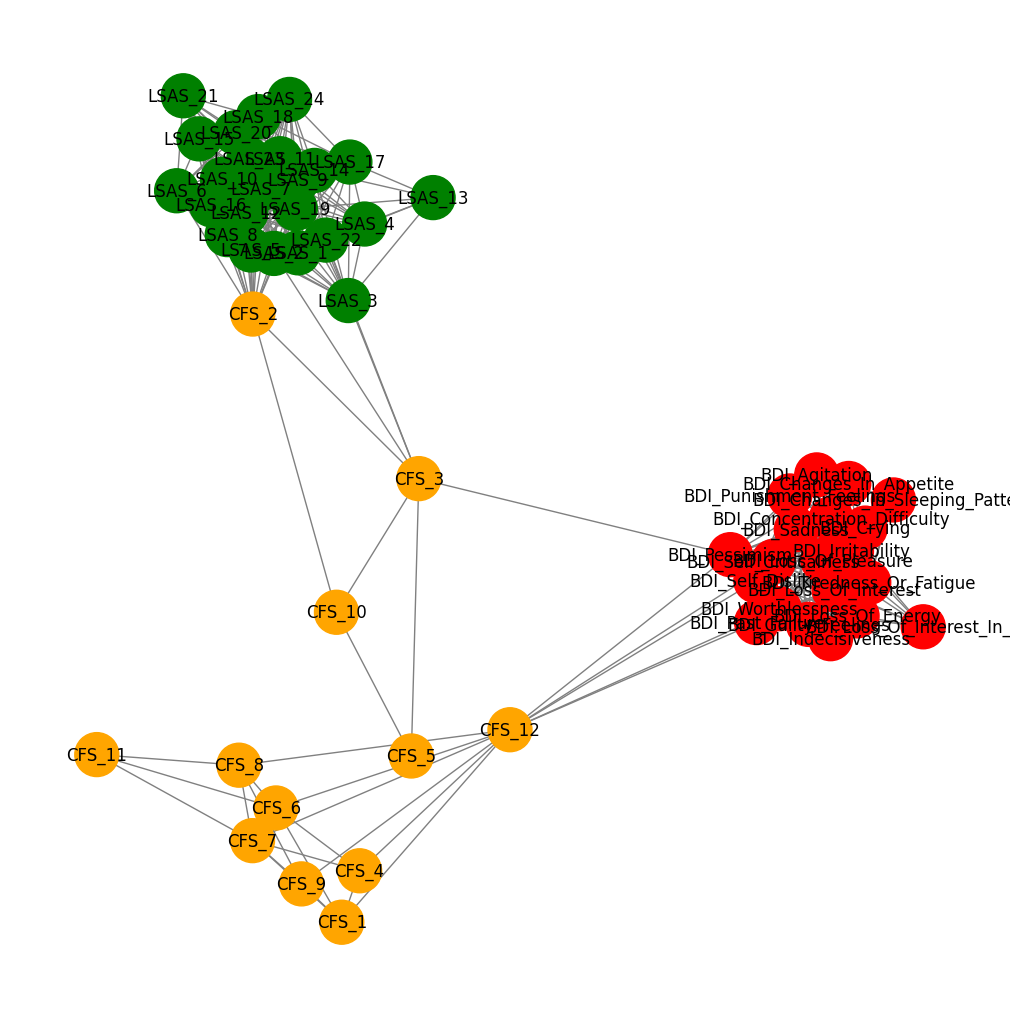

In [5]:
import networkx as nx
import matplotlib.pyplot as plt


# Define a function to color nodes based on their survey type
def get_node_color(node):
    if "LSAS" in node:
        return 'green'
    elif "CFS" in node:
        return 'orange'
    elif "BDI" in node:
        return 'red'
    else:
        return 'gray'  # Default color for unrecognized nodes

# Assign colors to nodes based on their labels
node_colors = [get_node_color(node) for node in G.nodes]

# Define node positions using spring layout
pos = nx.spring_layout(G)  # You can also try other layouts like nx.circular_layout(G)


# Create the plot
plt.figure(figsize=(10, 10))

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray')

# Show the plot
plt.show()

TypeError: Object of type ndarray is not JSON serializable

#### Descriptive Statistics

Number of nodes: 56
Number of edges: 444
Network density: 0.2883116883116883


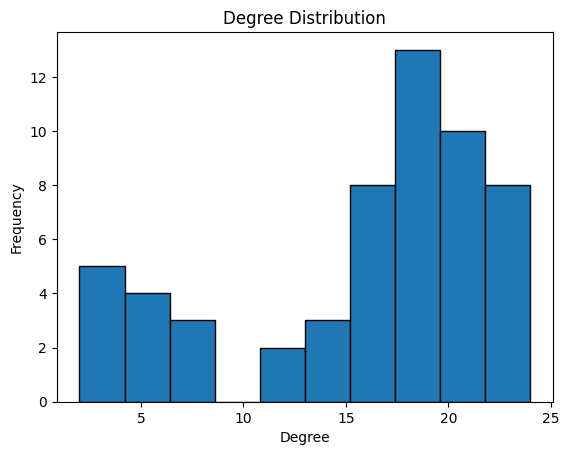

In [6]:
# Basic network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
density = nx.density(G)
print(f"Network density: {density}")

# Degree distribution
degrees = [deg for node, deg in G.degree()]
plt.hist(degrees, bins=10, edgecolor='black')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()


#### Community Detection and Visualization

Number of communities: 3
Modularity score: 0.52062145290988


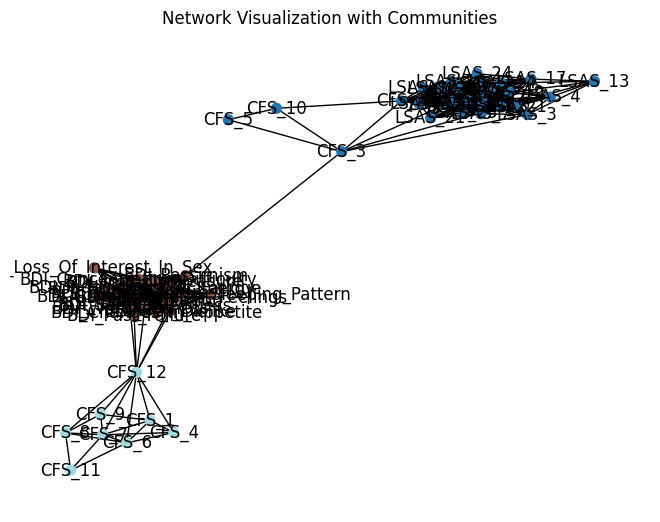

{'Community 1': ['LSAS_1',
  'LSAS_4',
  'LSAS_2',
  'LSAS_6',
  'LSAS_15',
  'LSAS_11',
  'CFS_10',
  'LSAS_24',
  'LSAS_22',
  'LSAS_5',
  'LSAS_20',
  'LSAS_7',
  'LSAS_9',
  'LSAS_21',
  'CFS_2',
  'LSAS_12',
  'LSAS_18',
  'LSAS_8',
  'LSAS_13',
  'LSAS_14',
  'LSAS_3',
  'LSAS_19',
  'LSAS_17',
  'LSAS_10',
  'CFS_5',
  'LSAS_23',
  'LSAS_16',
  'CFS_3'],
 'Community 2': ['BDI_Past_Failure',
  'BDI_Loss_Of_Energy',
  'BDI_Punishment_Feelings',
  'BDI_Irritability',
  'BDI_Loss_Of_Interest',
  'BDI_Loss_Of_Interest_In_Sex',
  'BDI_Concentration_Difficulty',
  'BDI_Changes_In_Sleeping_Pattern',
  'BDI_Guilty_Feelings',
  'BDI_Tiredness_Or_Fatigue',
  'BDI_Crying',
  'BDI_Agitation',
  'BDI_Self_Dislike',
  'BDI_Changes_In_Appetite',
  'BDI_Loss_Of_Pleasure',
  'BDI_Sadness',
  'BDI_Worthlessness',
  'BDI_Pessimism',
  'BDI_Indecisiveness',
  'BDI_Self_Criticalness'],
 'Community 3': ['CFS_11',
  'CFS_4',
  'CFS_6',
  'CFS_12',
  'CFS_7',
  'CFS_8',
  'CFS_9',
  'CFS_1']}

In [7]:
from networkx.algorithms import community
import matplotlib.pyplot as plt

# Greedy modularity optimization
communities = community.greedy_modularity_communities(G)
modularity = community.modularity(G, communities)

print(f"Number of communities: {len(communities)}")
print(f"Modularity score: {modularity}")

# Visualizing the network with communities
color_map = {}
for i, community_nodes in enumerate(communities):
    for node in community_nodes:
        color_map[node] = i  # Assign each community a unique color

# Plot the network
colors = [color_map[node] for node in G.nodes()]
nx.draw(G, with_labels=True, node_color=colors, cmap=plt.cm.tab20, node_size=50)
plt.title('Network Visualization with Communities')
plt.show()


# Extracting communities from the outputs
communities_output = [
    "['LSAS_1', 'LSAS_4', 'LSAS_2', 'LSAS_6', 'LSAS_15', 'LSAS_11', 'CFS_10', 'LSAS_24', 'LSAS_22', 'LSAS_5', 'LSAS_20', 'LSAS_7', 'LSAS_9', 'LSAS_21', 'CFS_2', 'LSAS_12', 'LSAS_18', 'LSAS_8', 'LSAS_13', 'LSAS_14', 'LSAS_3', 'LSAS_19', 'LSAS_17', 'LSAS_10', 'CFS_5', 'LSAS_23', 'LSAS_16', 'CFS_3']",
    "['BDI_Past_Failure', 'BDI_Loss_Of_Energy', 'BDI_Punishment_Feelings', 'BDI_Irritability', 'BDI_Loss_Of_Interest', 'BDI_Loss_Of_Interest_In_Sex', 'BDI_Concentration_Difficulty', 'BDI_Changes_In_Sleeping_Pattern', 'BDI_Guilty_Feelings', 'BDI_Tiredness_Or_Fatigue', 'BDI_Crying', 'BDI_Agitation', 'BDI_Self_Dislike', 'BDI_Changes_In_Appetite', 'BDI_Loss_Of_Pleasure', 'BDI_Sadness', 'BDI_Worthlessness', 'BDI_Pessimism', 'BDI_Indecisiveness', 'BDI_Self_Criticalness']",
    "['CFS_11', 'CFS_4', 'CFS_6', 'CFS_12', 'CFS_7', 'CFS_8', 'CFS_9', 'CFS_1']"
]

# Cleaning and organizing the community data
communities = [eval(community) for community in communities_output]

# Creating a structured output for clarity
community_members = {f"Community {i+1}": members for i, members in enumerate(communities)}

# Displaying the structured list of community members
community_members



Community 1 (LSAS and some CFS questions):
LSAS_1, LSAS_4, LSAS_2, LSAS_6, LSAS_15, LSAS_11, CFS_10, LSAS_24, LSAS_22, LSAS_5, LSAS_20, LSAS_7, LSAS_9, LSAS_21, CFS_2, LSAS_12, LSAS_18, LSAS_8, LSAS_13, LSAS_14, LSAS_3, LSAS_19, LSAS_17, LSAS_10, CFS_5, LSAS_23, LSAS_16, CFS_3

Community 2 (BDI questions):
BDI_Past_Failure, BDI_Loss_Of_Energy, BDI_Punishment_Feelings, BDI_Irritability, BDI_Loss_Of_Interest, BDI_Loss_Of_Interest_In_Sex, BDI_Concentration_Difficulty, BDI_Changes_In_Sleeping_Pattern, BDI_Guilty_Feelings, BDI_Tiredness_Or_Fatigue, BDI_Crying, BDI_Agitation, BDI_Self_Dislike, BDI_Changes_In_Appetite, BDI_Loss_Of_Pleasure, BDI_Sadness, BDI_Worthlessness, BDI_Pessimism, BDI_Indecisiveness, BDI_Self_Criticalness

Community 3 (CFS questions):
CFS_11, CFS_4, CFS_6, CFS_12, CFS_7, CFS_8, CFS_9, CFS_1

#### Centrality Measures

Top 10 nodes by degree centrality:
Node: LSAS_2, Centrality: 0.43636363636363634
Node: LSAS_11, Centrality: 0.41818181818181815
Node: LSAS_14, Centrality: 0.41818181818181815
Node: LSAS_19, Centrality: 0.41818181818181815
Node: LSAS_5, Centrality: 0.39999999999999997
Node: LSAS_7, Centrality: 0.39999999999999997
Node: LSAS_8, Centrality: 0.39999999999999997
Node: LSAS_12, Centrality: 0.39999999999999997
Node: LSAS_9, Centrality: 0.3818181818181818
Node: LSAS_16, Centrality: 0.3818181818181818


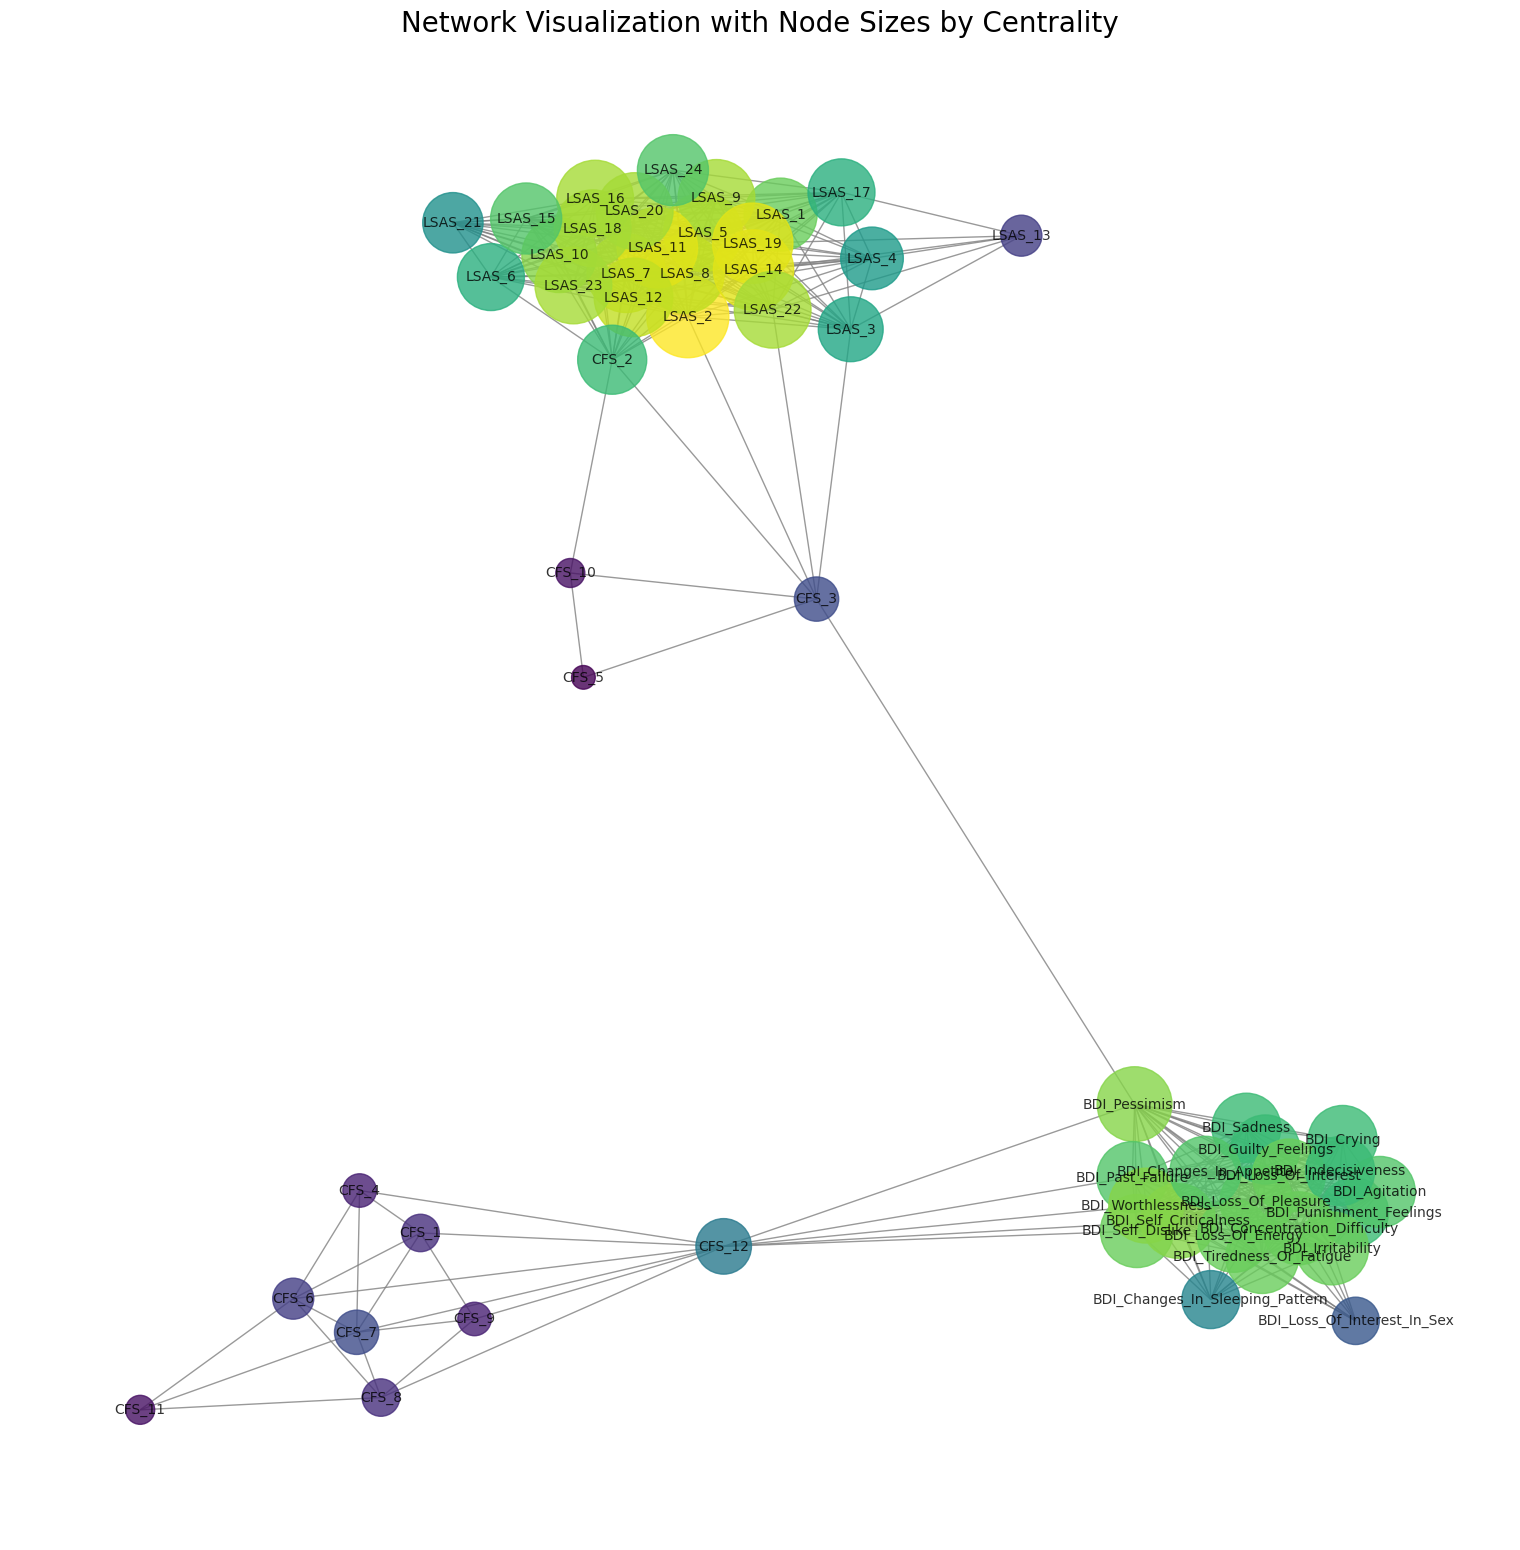

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Degree centrality
centrality = nx.degree_centrality(G)

# Top 10 central nodes
top_central_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by degree centrality:")
for node, centrality_score in top_central_nodes:
    print(f"Node: {node}, Centrality: {centrality_score}")

# Visualize centrality
node_sizes = [8000 * centrality[node] for node in G.nodes()]  # Adjusted scaling for clarity
plt.figure(figsize=(15, 15))  # Increase figure size
pos = nx.spring_layout(G, seed=42)  # Consistent layout for readability

# Draw the graph
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    cmap=plt.cm.viridis,
    node_color=list(centrality.values()),
    font_size=10,  # Larger font size for labels
    font_color='black',
    edge_color='gray',
    alpha=0.8
)
plt.title('Network Visualization with Node Sizes by Centrality', fontsize=20)
plt.show()


### Most/Least Connected Nodes

Shows nodes (questions) with the most and least degrees (number of connected edges)

In [9]:
import networkx as nx

# Assuming G is your graph from the previous steps

# Calculate the degree of each node
degree_dict = dict(G.degree())

# Find the most connected question(s)
most_connected = max(degree_dict, key=degree_dict.get)
most_connected_degree = degree_dict[most_connected]

# Find the least connected question(s)
least_connected = min(degree_dict, key=degree_dict.get)
least_connected_degree = degree_dict[least_connected]

# Print the results
print(f"Most connected question: {most_connected}: degree {most_connected_degree}")
print(f"Least connected question: {least_connected}: degree {least_connected_degree}")

# Sort nodes by their degree in descending order
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

# Print the results
print("Questions and their degrees (from highest to lowest):")
for question, degree in sorted_degree:
    print(f"{question}: {degree}")

Most connected question: LSAS_2: degree 24
Least connected question: CFS_5: degree 2
Questions and their degrees (from highest to lowest):
LSAS_2: 24
LSAS_11: 23
LSAS_14: 23
LSAS_19: 23
LSAS_5: 22
LSAS_7: 22
LSAS_8: 22
LSAS_12: 22
LSAS_9: 21
LSAS_16: 21
LSAS_18: 21
LSAS_20: 21
LSAS_22: 21
LSAS_23: 21
LSAS_10: 20
BDI_Pessimism: 20
BDI_Self_Criticalness: 20
BDI_Worthlessness: 20
LSAS_1: 19
BDI_Self_Dislike: 19
BDI_Loss_Of_Pleasure: 19
BDI_Loss_Of_Interest: 19
BDI_Loss_Of_Energy: 19
BDI_Irritability: 19
BDI_Concentration_Difficulty: 19
BDI_Tiredness_Or_Fatigue: 19
LSAS_24: 18
LSAS_15: 18
BDI_Past_Failure: 18
BDI_Agitation: 18
BDI_Changes_In_Appetite: 18
CFS_2: 17
BDI_Sadness: 17
BDI_Guilty_Feelings: 17
BDI_Punishment_Feelings: 17
BDI_Crying: 17
BDI_Indecisiveness: 17
LSAS_17: 16
LSAS_6: 16
LSAS_3: 15
LSAS_4: 14
LSAS_21: 13
BDI_Changes_In_Sleeping_Pattern: 12
CFS_12: 11
BDI_Loss_Of_Interest_In_Sex: 8
CFS_3: 7
CFS_7: 7
LSAS_13: 6
CFS_6: 6
CFS_1: 5
CFS_8: 5
CFS_4: 4
CFS_9: 4
CFS_10: 3
CFS_11

### Correlation Pairs (within-test allowed)

In [10]:
import pandas as pd
import numpy as np

# Assuming correlation_matrix is your DataFrame with correlations

# Set the diagonal elements to NaN to avoid self-pairing
np.fill_diagonal(correlation_matrix.values, np.nan)

# Find the maximum correlation value in the matrix
max_corr = correlation_matrix.max().max()

# Find the minimum correlation value in the matrix
min_corr = correlation_matrix.min().min()

# Find the pairs with the maximum correlation
max_corr_pairs = np.where(correlation_matrix == max_corr)
max_corr_questions = list(zip(correlation_matrix.columns[max_corr_pairs[0]], correlation_matrix.columns[max_corr_pairs[1]]))

# Find the pairs with the minimum correlation
min_corr_pairs = np.where(correlation_matrix == min_corr)
min_corr_questions = list(zip(correlation_matrix.columns[min_corr_pairs[0]], correlation_matrix.columns[min_corr_pairs[1]]))

# Print the results
print(f"Maximum correlation value: {max_corr}")
print("Pairs with the maximum correlation:")
for pair in max_corr_questions:
    print(f"{pair[0]} and {pair[1]}")

print(f"\nMinimum correlation value: {min_corr}")
print("Pairs with the minimum correlation:")
for pair in min_corr_questions:
    print(f"{pair[0]} and {pair[1]}")



Maximum correlation value: 0.8243014329145768
Pairs with the maximum correlation:
LSAS_11 and LSAS_12
LSAS_12 and LSAS_11

Minimum correlation value: 0.0306330444518164
Pairs with the minimum correlation:
LSAS_6 and CFS_11
CFS_11 and LSAS_6


In [11]:
import pandas as pd
import numpy as np

# Assuming correlation_matrix is your DataFrame with correlations

# Set the diagonal elements to NaN to avoid self-pairing
np.fill_diagonal(correlation_matrix.values, np.nan)

# Function to determine if two columns belong to different tests
def different_tests(col1, col2):
    if (col1 in lsas_columns and col2 in lsas_columns) or \
       (col1 in cfs_columns and col2 in cfs_columns) or \
       (col1 in bdi_columns and col2 in bdi_columns):
        return False
    return True

# Function to get top N unique pairs (max or min correlations)
def get_top_n_pairs(correlation_matrix, n, max_or_min="max"):
    # Flatten the matrix to get correlations and pairs
    corr_unstacked = correlation_matrix.unstack()
    
    # Sort by correlation value
    if max_or_min == "max":
        sorted_corr = corr_unstacked.sort_values(ascending=False)
    else:
        sorted_corr = corr_unstacked.sort_values(ascending=True)
    
    # Filter out reverse pairs and pairs from the same test
    unique_pairs = []
    seen = set()
    for (col1, col2), corr_value in sorted_corr.items():
        if (col1, col2) not in seen and (col2, col1) not in seen and different_tests(col1, col2):
            unique_pairs.append((col1, col2, corr_value))
            seen.add((col1, col2))
            seen.add((col2, col1))  # Mark reverse pair as seen
        if len(unique_pairs) == n:
            break
    return unique_pairs

# Get 5 unique pairs with the highest correlations
highest_corr_pairs = get_top_n_pairs(correlation_matrix, 5, max_or_min="max")

# Get 5 unique pairs with the lowest correlations
lowest_corr_pairs = get_top_n_pairs(correlation_matrix, 5, max_or_min="min")

# Print the results
print("Top 5 pairs with the highest correlation (from different tests):")
for pair in highest_corr_pairs:
    print(f"{pair[0]} and {pair[1]} with correlation {pair[2]:.4f}")

print("\nTop 5 pairs with the lowest correlation (from different tests):")
for pair in lowest_corr_pairs:
    print(f"{pair[0]} and {pair[1]} with correlation {pair[2]:.4f}")


Top 5 pairs with the highest correlation (from different tests):
CFS_2 and LSAS_11 with correlation 0.5533
CFS_2 and LSAS_12 with correlation 0.5398
LSAS_16 and CFS_2 with correlation 0.5250
LSAS_2 and CFS_2 with correlation 0.5102
CFS_2 and LSAS_15 with correlation 0.5066

Top 5 pairs with the lowest correlation (from different tests):
LSAS_6 and CFS_11 with correlation 0.0306
CFS_11 and LSAS_21 with correlation 0.0315
LSAS_13 and CFS_4 with correlation 0.0428
CFS_11 and LSAS_18 with correlation 0.0644
LSAS_3 and CFS_4 with correlation 0.0652


# Next steps: 

Find out how to stratify by type of test, so that I can see highest correlations between items of different tests. RIght now we're just getting the avoidance/fear equivalent questions from the LSAS. Also don't make it say the pair backwards.